<a href="https://colab.research.google.com/github/jangelcode/super-duper/blob/main/machinelearning/Titanic_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training Model

In [ ]:
pip install fastai==0.7.0

In [ ]:
from fastai import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [ ]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    print(big_string)
    return np.nan

In [ ]:
def replace_titles(x):
      title=x['Title']
      if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
           return 'Mr'
      elif title in ['Countess', 'Mme']:
           return 'Mrs'
      elif title in ['Mlle', 'Ms']:
           return 'Miss'
      elif title =='Dr':
          if x['Sex']=='Male':
              return 'Mr'
          else:
              return 'Mrs'
      else:
          return title

In [ ]:
df = pd.read_csv("train.csv")
df['label'] = 'train'

test_df = pd.read_csv("test.csv")
test_df['label'] = 'test'

In [ ]:
modeEmbarked = stats.mode(df['Embarked'])
df['Embarked'] = df['Embarked'].fillna(modeEmbarked)

modeEmbarked2 = stats.mode(test_df['Embarked'])
test_df['Embarked'] = test_df['Embarked'].fillna(modeEmbarked2)

meanAge= np.mean(df['Age'])
df['Age']= df['Age'].fillna(meanAge)

meanAge2= np.mean(test_df['Age'])
test_df['Age']= test_df['Age'].fillna(meanAge2)

In [ ]:
concat_df = pd.concat([df , test_df])

In [ ]:
concat_df['Cabin'] = concat_df['Cabin'].fillna('Unknown')
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T','G', 'Unknown']
concat_df['Deck']=concat_df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

In [ ]:
features_df = pd.get_dummies(concat_df,columns=["Embarked", "Deck"],prefix=["Embarked", "Deck"])

features_df["Sex"] = np.where(features_df["Sex"].str.contains("female"),1,0)

features_df['Family_Size']=features_df['SibSp']+features_df['Parch']

In [ ]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']
features_df['Title']=features_df['Name'].map(lambda x: substrings_in_string(x, title_list))
features_df['Title']=features_df.apply(replace_titles, axis=1)
features_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'label', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Deck_Unknown', 'Family_Size', 'Title'],
      dtype='object')

In [ ]:
features_df['Fare'] = features_df['Fare'].map(lambda x: np.nan if x==0 else x).fillna(0)
features_df['Fare_Per_Person']=features_df['Fare']/(features_df['Family_Size']+1)

In [ ]:
features_df = pd.get_dummies(features_df, columns=['Title'], prefix=['Title'])

In [ ]:
features_df = features_df.drop(columns=['Name', 'Ticket', 'Cabin', 'Deck_T'])

df = features_df[features_df['label'] == 'train']
test_df = features_df[features_df['label'] == 'test']

df = df.drop('label', axis=1)
test_df = test_df.drop('label', axis=1)

In [ ]:
df['Fare_Per_Person'] = df["Fare_Per_Person"].fillna(stats.mean(df['Fare_Per_Person']))

test_df['Fare_Per_Person'] = test_df["Fare_Per_Person"].fillna(np.mean(test_df['Fare_Per_Person']))

In [ ]:
df= df.drop(columns="PassengerId")
y, df = df.iloc[:,0], df.drop(columns = 'Survived')

In [ ]:
y.head()

0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
Name: Survived, dtype: float64

In [ ]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9865319865319865

In [ ]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 200
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((691, 23), (691,), (200, 23))

In [ ]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [ ]:
df.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Unknown,Family_Size,Fare_Per_Person,Title_Master,Title_Miss,Title_Mr,Title_Mrs
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.725028,0.016835,0.052750,0.066218,0.037037,0.037037,0.013468,0.004489,0.771044,0.904602,19.916375,0.044893,0.204265,0.595960,0.154882
std,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.391372,0.281141,0.446751,0.128725,0.223659,0.248802,0.188959,0.188959,0.115332,0.066890,0.420397,1.613459,35.841257,0.207186,0.403390,0.490981,0.361996
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.250000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.300000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,23.666667,0.000000,0.000000,1.000000,0.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,512.329200,1.000000,1.000000,1.000000,1.000000


In [ ]:
import math

m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 262 ms, sys: 37 ms, total: 299 ms
Wall time: 358 ms
[0.11412537853628002, 0.4301162633521313, 0.9869753979739508, 0.815]


In [ ]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.4149869664753682, 0.41231056256176607, 0.8277858176555717, 0.83]


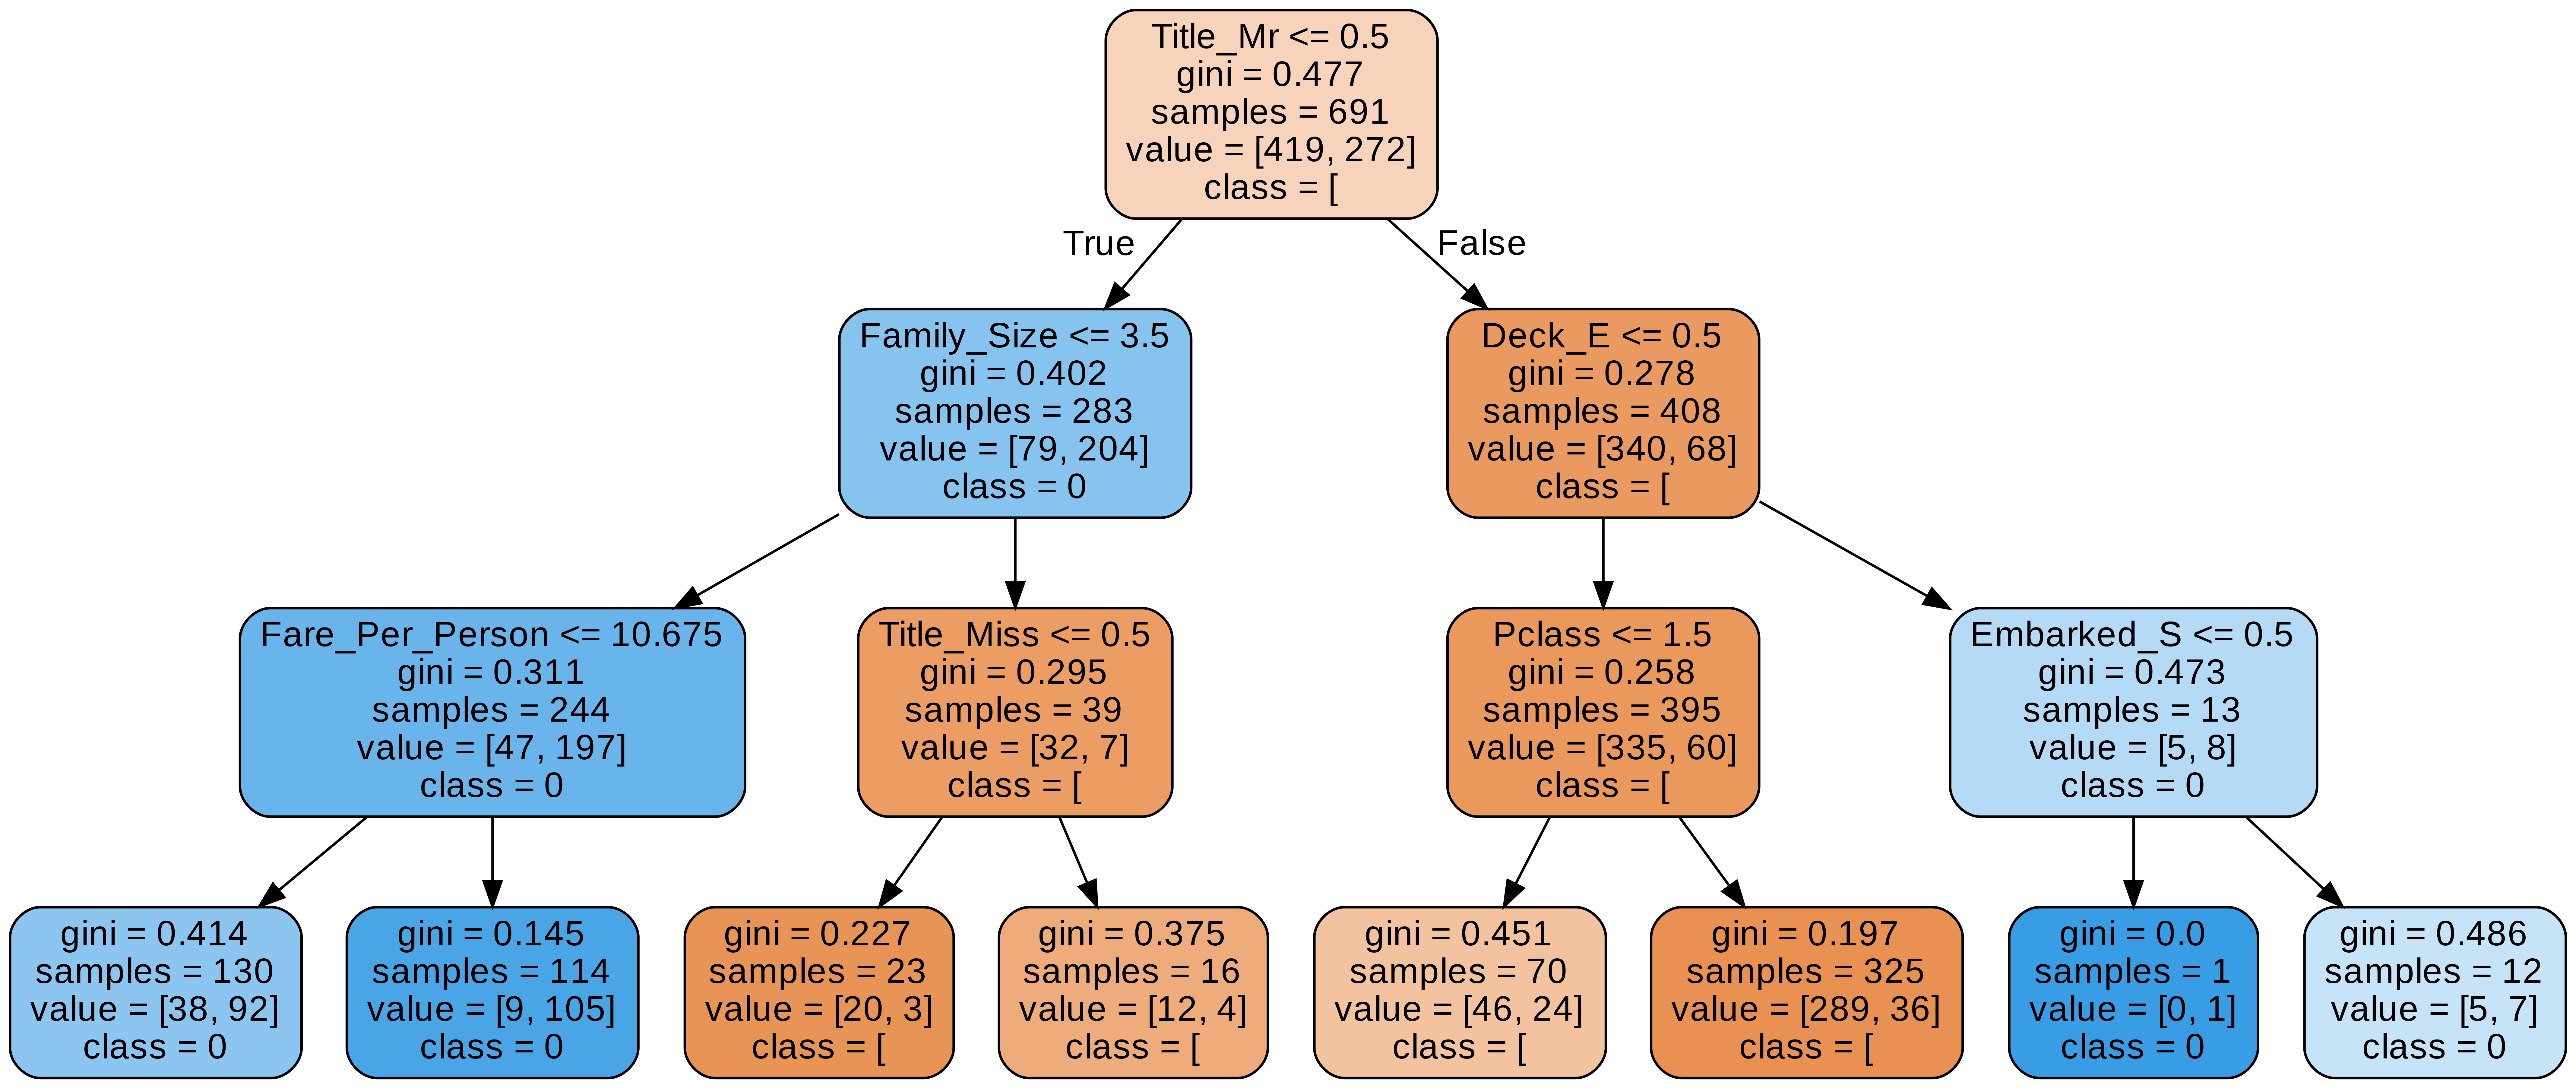

In [ ]:
estimator = m.estimators_[0]

tree.export_graphviz(estimator, out_file='tree.dot', 
                feature_names = df.columns,
                class_names = str(np.unique(m.classes_)),
                rounded = True, proportion = False, 
                precision = 3, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

#BAGGING

In [ ]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.12029871166784604, 0.4242640687119285, 0.9855282199710564, 0.82]


In [ ]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[:5]

(array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 0.99,
 691    1.0
 692    1.0
 693    1.0
 694    0.0
 695    0.0
 Name: Survived, dtype: float64)

In [ ]:
preds.shape

(100, 200)

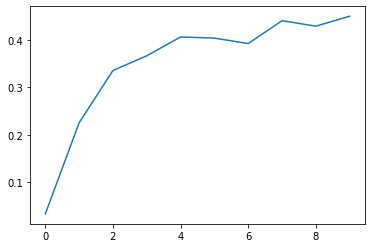

In [ ]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [ ]:
m = RandomForestClassifier(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.12617035322070677, 0.4472135954999579, 0.984081041968162, 0.8]


In [ ]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11412537853628002, 0.44158804331639234, 0.9869753979739508, 0.805]


In [ ]:
m = RandomForestClassifier(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11412537853628002, 0.4242640687119285, 0.9869753979739508, 0.82]


#OOB-Score

In [ ]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12029871166784604, 0.4301162633521313, 0.9855282199710564, 0.815, 0.7959479015918958]


#Reduce Over-Fitting

In [ ]:
n_valid = 200
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [ ]:
m = RandomForestClassifier(n_estimators =40, n_jobs=-1, min_samples_leaf=3,oob_score=False, max_samples=0.5)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 90.1 ms, sys: 13.9 ms, total: 104 ms
Wall time: 123 ms
[0.3608961350035382, 0.4, 0.869753979739508, 0.84]


# Test Data

In [ ]:
passID = test_df['PassengerId']
test_df = test_df.drop(columns=['PassengerId', 'Survived'])

In [ ]:
prediction = pd.DataFrame(m.predict(test_df[:-1]),columns=["Survived"])

In [ ]:
results = [passID, prediction["Survived"]]
headers = ["PassengerId", "Survived"]
df3 = pd.concat(results, axis=1, keys=headers)

In [ ]:
submission = pd.DataFrame(df3).to_csv("submission.csv")